In [23]:
%load_ext autoreload
%autoreload 2
# %matplotlib qt
# %matplotlib qt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import logging

In [25]:
def zscore_3d(arr):
    # 计算沿第三维（axis=2）的均值和标准差
    means = np.mean(arr, axis=(0, 1), keepdims=True)
    stds = np.std(arr, axis=(0, 1), keepdims=True)
    # print(means.shape)
    # print(stds.shape)
    # 执行Z-score标准化
    zscored = (arr - means) / stds
    
    return zscored

In [26]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os


hdf5_file = '../datasets/mSM36/05-Dec-2017-wpaw/data.hdf5'
numpy_dir = os.path.join('..', 'numpy_arrays')


region_dict = {}
with h5py.File(hdf5_file, 'r', libver='latest', swmr=True) as file:
    # collect region index names
    regions = list(file['regions']['indxs_consolidate_lr'].keys())
    # print out
    for region in regions:
        region_idxs = file['regions']['indxs_consolidate_lr'][region][()]
        print('%s: %i dims' % (region, region_idxs.shape[1]))
        region_dict[region] = region_idxs


ACAd1_L: 8 dims
ACAd1_R: 7 dims
AUD_L: 4 dims
AUD_R: 7 dims
FRP1_L: 6 dims
FRP1_R: 12 dims
MOB_L: 14 dims
MOB_R: 9 dims
MOp_L: 7 dims
MOp_R: 6 dims
MOs_L: 14 dims
MOs_R: 14 dims
PL1_L: 7 dims
PL1_R: 7 dims
RSP_L: 15 dims
RSP_R: 11 dims
SSp_L: 23 dims
SSp_R: 22 dims
SSs1_L: 7 dims
SSs1_R: 7 dims
TEa1_L: 3 dims
TEa1_R: 3 dims
VIS_L: 24 dims
VIS_R: 21 dims


In [27]:
region_name_1, region_name_2 = "VIS_R", "VIS_L"

# neural_file = '../datasets/WFCI/C_' + region_name + '_neural_array.npy'
neural_file = '../datasets/WFCI/neural_whole_array-05-Dec.npy'
latents_label_file = '../datasets/WFCI/behavioral_labels_psvae_7.npy'
# gtruth_label_file = '../datasets/psvae-mSM36/05-Dec-2017-wpaw/behavioral_gtruth_labels_5.npy'

behavior_indices = [0,1,3,4,5,6]
seed = 2027
neural_region_array_1 = np.load(neural_file)[:,:,region_dict[region_name_1][0]]
neural_region_array_2 = np.load(neural_file)[:,:,region_dict[region_name_2][0]]
label_whole_array = np.load(latents_label_file)[:,:,behavior_indices]

print(region_name_1 + " neural_region_array shape:", neural_region_array_1.shape)
print(region_name_2 + " neural_region_array shape:", neural_region_array_2.shape)
print("label_whole_array shape:", label_whole_array.shape)
# Z-Scored

neural_whole_array_1 = zscore_3d(neural_region_array_1)
neural_whole_array_2 = zscore_3d(neural_region_array_2)
label_whole_array = zscore_3d(label_whole_array)
# neural_whole_array = np.concatenate((neural_whole_array,label_whole_array), axis=-1)

# neural_whole_array.shape, label_whole_array.shape

VIS_R neural_region_array shape: (549, 189, 21)
VIS_L neural_region_array shape: (549, 189, 24)
label_whole_array shape: (549, 189, 6)


In [28]:
trial_number, trial_length, neuron_number_1 = neural_whole_array_1.shape
trial_number, trial_length, neuron_number_2 = neural_whole_array_2.shape
trial_number, trial_length, label_number = label_whole_array.shape

neural_trial_to2d_array_1 = neural_whole_array_1.reshape(trial_number * trial_length, neuron_number_1)
neural_trial_to2d_array_2 = neural_whole_array_2.reshape(trial_number * trial_length, neuron_number_2)
label_trial_to2d_array = label_whole_array.reshape(trial_number * trial_length, label_number)
# neural_trial_cluster_array.shape, label_trial_cluster_array.shape

In [29]:
neural_whole_array_1[2,:10].shape

(10, 21)

In [83]:
from sklearn.cross_decomposition import CCA


cca_dims = 2
cca = CCA(n_components=cca_dims)

neural_trial_to2d_cca_1, neural_trial_to2d_cca_2 = cca.fit_transform(neural_whole_array_1[18,10:30,:75], neural_whole_array_2[18,10:30,:75])


In [84]:
neural_trial_to2d_cca_1.shape

(20, 2)

In [85]:
neural_trial_to2d_cca_2.shape

(20, 2)

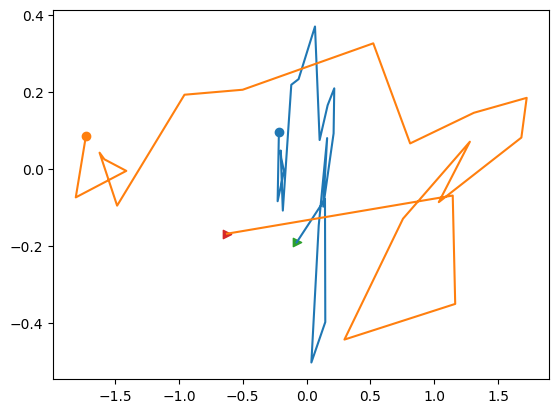

In [87]:
plt.plot(neural_trial_to2d_cca_1[:,0], neural_trial_to2d_cca_1[:,1])
plt.plot(neural_trial_to2d_cca_2[:,0], neural_trial_to2d_cca_2[:,1])

plt.scatter(neural_trial_to2d_cca_1[0,0], neural_trial_to2d_cca_1[0,1])
plt.scatter(neural_trial_to2d_cca_2[0,0], neural_trial_to2d_cca_2[0,1])

plt.scatter(neural_trial_to2d_cca_1[-1,0], neural_trial_to2d_cca_1[-1,1], marker='>')
plt.scatter(neural_trial_to2d_cca_2[-1,0], neural_trial_to2d_cca_2[-1,1], marker='>')